# Variational Auto Encoder

Deep generative models are those neural network architectures & algorithms that learn the key characteristics of the input data set, to generate similar data. There are various approaches to deep generative modelling, like VAEs (variational Auto Encoders), GANs (Generative Adversarial Networks) and Diffusion models. Each have their own approach of learning the underlying characteristics of the data to generate similar samples. Among the generative models, auto-encoders are specialized at learning the underlying distribution of the data.

In general autoencoders consists of two neural network models - Encoder Model and a Decoder Model. The encoder model is a series of neural network layers that learn the distribution of the data (latent vector) by reducing the dimensionality of the input space to a compressed vector. The decoder model is another neural network model that uses the compressed vector to learn and generate new samples. However, there is a few fundamental problems associated with traditional encoders. 

1. The learnt compressed vector in autoencoders does not follow any distribution rules. This is because each input is learnt independently, as a result the outcome (latent vector) of any two data points belonging to same class can have different lower/upper bounds. For example, a latent vector learnt for an image of dog can be from -15 to 20 in a 1D dimension, where as another image from the same class can have a lower and upper bounds of -1 to 1.5. 
2. The latent space distribution is not continuous, the samples from same class could be very far from each other.

Thus, in traditional autoencoders lack of proper shape, distribution rules in the learnt vector makes it difficult to renegerate new samples of same class. Variation autoencoders solve this problem by forcing the encoder to learn the latent space distribution as a standard normal distribution. The standard normal distribution makes it easy to draw new samples. 

The below diagram shows the high level network architecture of VAE

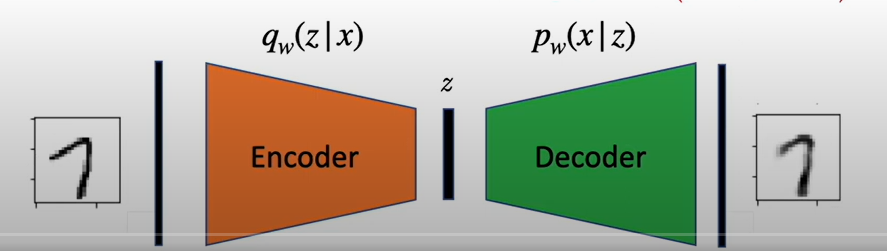

In this notebook we will learn to build a variational auto encoder using the face images dataset, tensforflow.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
import glob

print(tf.__version__)
print(np.__version__)


2.12.0
1.23.5


## Download dataset

In [78]:
import shutil
src_path = r"/kaggle/input/smiling-or-not-face-data/"
dst_path = r"/kaggle/working/"
os.makedirs(os.path.dirname(dst_path + 'train/non_smile'), exist_ok=True)
os.makedirs(os.path.dirname(dst_path + 'train/smile'), exist_ok=True)
def copy_and_overwrite(from_path, to_path):
    if os.path.exists(to_path):
        shutil.rmtree(to_path)
    shutil.copytree(from_path, to_path)
copy_and_overwrite(src_path+'non_smile/', dst_path + '/train/non_smile')
copy_and_overwrite(src_path+'smile/', dst_path + '/train/smile')
print('Copied')

Copied


In [79]:
main_path = '/kaggle/working/train/'
folders = ['non_smile', 'smile']
img_height, img_width = 128, 128
batch_size = 32

list_files = [glob.glob(main_path + images + '/*.jpg') for images in folders]
list_files = list_files[0] + list_files[1]
image_count = len(list_files)
print(f'Length of files: {image_count}')

Length of files: 1203


In [80]:
smile_train_ds = tf.keras.utils.image_dataset_from_directory(
  main_path + '/smile',
  seed=123,
  image_size=(img_height, img_width),
  label_mode=None,
  batch_size=batch_size)

nosmile_train_ds = tf.keras.utils.image_dataset_from_directory(
  main_path + '/non_smile',
  label_mode=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 600 files belonging to 1 classes.
Found 603 files belonging to 1 classes.


Image shape:  (32, 128, 128, 3)


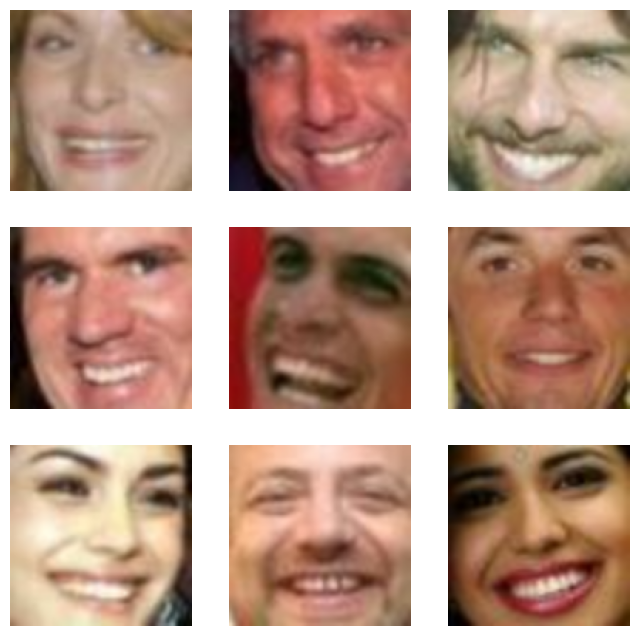

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
class_names = folders

for images in smile_train_ds.take(1):
    print("Image shape: ", images.numpy().shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Preprocess

In [82]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

def pre_process(x):
    x = normalization_layer(x)
    return x
    
n_smile_train_ds = smile_train_ds.map(lambda x: pre_process(x))  
n_val_ds = val_ds.map(lambda x: pre_process(x))

## Encoder model.

In the Encoder layer we compress the input data to a vector fo size 16.



In [105]:
input_data = tf.keras.layers.Input(shape=(img_height, img_width, 3))
encoder = tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=2)(input_data)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2)(encoder)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2)(encoder)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2)(encoder)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Flatten()(encoder)
encoder = tf.keras.layers.Dense(4096)(encoder)

## Mean and Variance vector.

The output of the encoder is further reduced to 2 dimension vector.
The output is then passed through a lambda function that calculates epsilon.
Epsilon is the random normal distribution, the size of the sample must be equal to batch size. 
Finally we apply the log var trick, as explained in the below equation

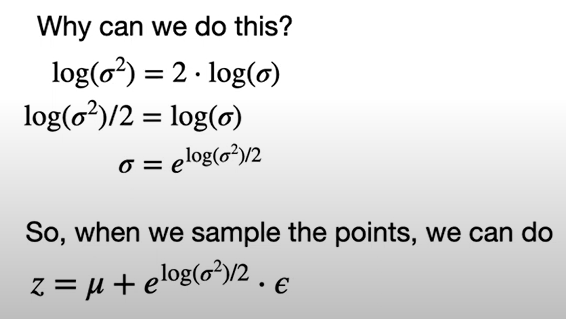

z => represents the final value
u => mean
sigma => variance
epsilon => random normal distribution of mean  = 0, and standard deviation = 1


In [106]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.keras.backend.shape(distribution_mean)
    epsilon = tf.keras.backend.random_normal(shape=batch_size, mean=0, stddev=1)
    return distribution_mean + tf.exp(0.5 * distribution_variance) * epsilon
 
dist_mean = tf.keras.layers.Dense(200, name='mean')(encoder)
dist_variance = tf.keras.layers.Dense(200, name='log_variance')(encoder)
latent_encoding = tf.keras.layers.Lambda(sample_latent_features)([dist_mean, dist_variance])
encoder_model = tf.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 63, 63, 32)   896         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 63, 63, 32)  128         ['conv2d_19[0][0]']              
 rmalization)                                                                                     
                                                                                            

## Decoder Model

The decoder model does the opposite, it takes the latent vector and performs deconvolution and upsampling to reconstruct the images

In [118]:
decoder_input = tf.keras.layers.Input(shape=(200))
decoder = tf.keras.layers.Dense(4096)(decoder_input)
decoder = tf.keras.layers.Reshape((8, 8, 64))(decoder)

decoder = tf.keras.layers.Conv2DTranspose(64, (2,2), activation='relu', strides=2)(decoder)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.Dropout(0.25)(decoder)

decoder = tf.keras.layers.Conv2DTranspose(64, (2,2), activation='relu', strides=2)(decoder)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.Dropout(0.25)(decoder)

decoder = tf.keras.layers.Conv2DTranspose(32, (2,2), activation='relu', strides=2)(decoder)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.Dropout(0.25)(decoder)

decoder_output = tf.keras.layers.Conv2DTranspose(3, (2,2), activation='relu', strides=2)(decoder)
decoder_model = tf.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 200)]             0         
                                                                 
 dense_19 (Dense)            (None, 4096)              823296    
                                                                 
 reshape_14 (Reshape)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_60 (Conv2D  (None, 16, 16, 64)       16448     
 Transpose)                                                      
                                                                 
 batch_normalization_34 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 16, 16, 64)        0  

## Loss Function

The loss function here has two objectives. The first term ensures the reconstruction loss is minimum, and the second term ensures that the distribution of latent vector is near to standard normal distribution also called KL-divergence.

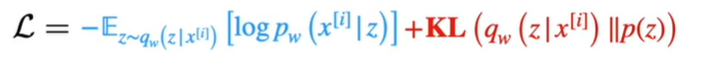

The first term is implemented as MSE, i.e. the mean squared error of predicted data vs. actual data. 

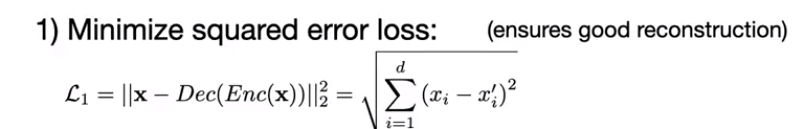

The second term is implemented using function shown below.

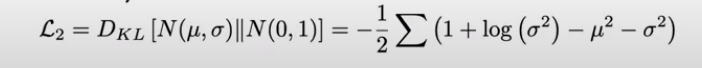

For a SND, when mean = 0, and variance is 1. The L2 loss becomes 0. 

Finally the losses are combined

In [119]:
optimizer = tf.keras.optimizers.legacy.Adam(lr = 0.0005)

def get_reconstruction_loss(y_true, y_pred):
    reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
    reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
    return reconstruction_loss_batch * img_width * img_height
    
def get_kl_loss(distribution_mean, distribution_variance):
    kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
    kl_loss_batch = tf.reduce_mean(kl_loss)
    return kl_loss_batch * (-0.5)
    
def vae_loss(y_true, y_pred, distribution_mean, distribution_variance):
    reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
    kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
    return reconstruction_loss_batch + kl_loss_batch

## Training

In [120]:
@tf.function
def train_step(images):
    with tf.GradientTape() as enc, tf.GradientTape() as dec:
        latent = encoder_model(images)
        generated_images = decoder_model(latent)
        loss = vae_loss(images, generated_images, latent[0], latent[1])
    gradients_of_enc = enc.gradient(loss, encoder_model.trainable_variables)
    gradients_of_dec = dec.gradient(loss, decoder_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_enc, encoder_model.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, decoder_model.trainable_variables))
    return loss

In [121]:
import tqdm

epochs = 100
losses = []

def train(dataset, epochs):
    for epoch in tqdm.tqdm(range(epochs)):
        for image_batch in dataset:
            loss = train_step(image_batch)
            losses.append(loss)

train(n_smile_train_ds, epochs)

100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


## Plot Loss

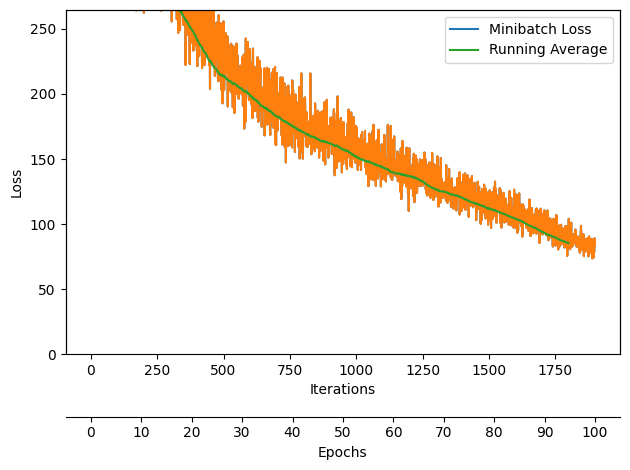

In [122]:
def plot_train_loss(t_losses, num_epochs, averaging_iterations=100, custom_label = ''):
    plt.figure()
    iter_per_epoch = len(t_losses) // num_epochs
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(t_losses)),(t_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    plt.plot(t_losses)
    if len(t_losses) < 1000:
        num_losses = len(t_losses) // 2
    else:
        num_losses = 1000
    ax1.set_ylim([0, np.max(t_losses[num_losses:])*1.5])
    ax1.plot(np.convolve(t_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()
    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))
    newpos = [e*iter_per_epoch for e in newlabel]
    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################
    plt.tight_layout()

plot_train_loss(losses, epochs)

## Generate images from latent space

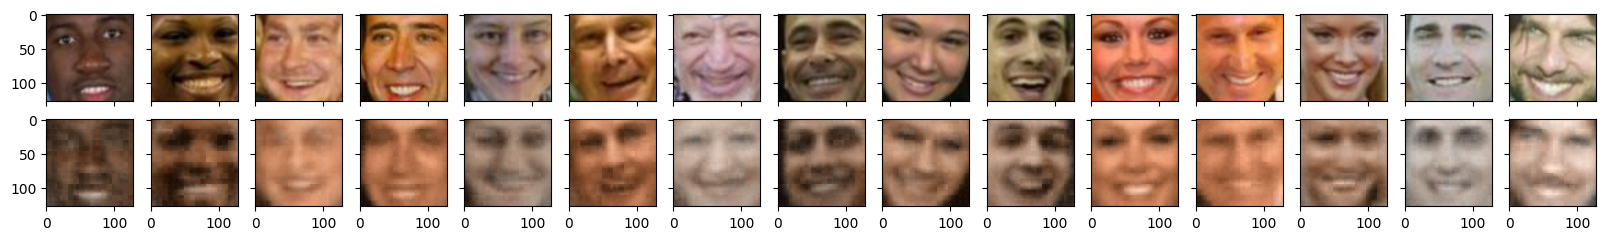

In [123]:
def plot_generated_images(data_loader, model, unnormalizer=None, figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    orig_images = []
    pred_images = []
    for img in next(data_loader.as_numpy_iterator()):
        color_channels = 3
        image_height = img_height
        image_width = img_width
        latent = encoder_model(img.reshape(1, image_height, image_width, color_channels))
        predictions = decoder_model(latent)[0]
        pred_images.append(predictions)
        orig_images.append(img)
    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, pred_images]):
            curr_img = img[i]
            ax[i].imshow(curr_img)

plot_generated_images(n_smile_train_ds, decoder_model)

The images are blurred due to the low dimensionality of the latent vector. Variational Autoencoders(VAEs) are not designed to reconstruct the images, the purpose is only to learn the underlying distribution. 

## Visualize learnt distribution 
Next we will plot the distribution of the data for all the classes. You should notice that the data distribution is centered at zero.
Embeddings of the same class are also next to each other. 

## Autoencoder as generative model

We can also use the decoder to generate images from random noise. 

1/1 [==============================] - 0s 23ms/step


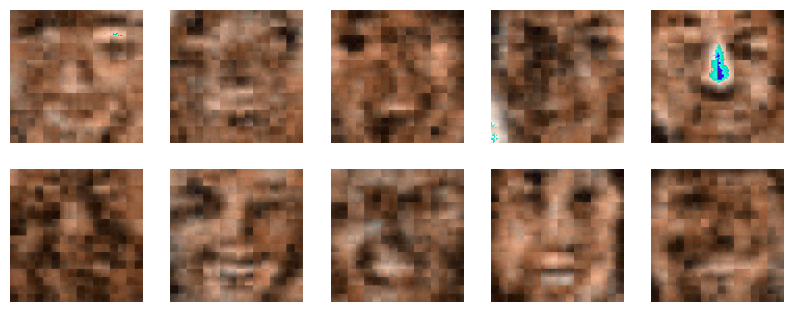

In [129]:
def plot_generated_images_vae(model, n_images=10, figsize = (10, 10)):
    generator_model = model
    fig = plt.figure(figsize=figsize)
    for i in range(n_images):
        ax = fig.add_subplot(5, 5, i+1)
        x = np.random.normal(size = (32,200))
        reconstruct = generator_model.predict(x)[0]
        ax.axis('off')
        pred = reconstruct * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        ax.imshow(pred)

plot_generated_images_vae(decoder_model)
